In [1]:
import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import math
import csv

import scipy.io
from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [2]:
stock_list = []
with open('Data/_lista_ativos.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        stock_list.append(row[0])

# stock_list =  ['PETR', 'ITUB', 'BBDC', 'ABEV', 'VALE', 'BBAS', 'GOLL', 'VIVT', 'B3SA', 'JBSS', 'AZUL', 'ELET', 'SUZB',
#                'WEGE', 'CRFB', 'MGLU', 'EGIE', 'LREN', 'SBSP', 'IRBR', 'CCRO', 'LAME', 'GGBR', 'HAPV', 'NATU', 'RADL',
#                'BRFS', 'CSNA', 'CIEL', 'HYPE', 'EQTL', 'KLBN', 'COGN', 'PSSA', 'MULT', 'BTOW', 'PMAM', 'EMBR', 'MDIA',
#                'UGPA', 'ENBR', 'USIM', 'CGAS', 'ODPV', 'TAEE', 'YDUQ', 'OIBR', 'MRVE', 'DTEX', 'SAPR', 'CVCB', 'ENEV',
#                'SMTO', 'LCAM', 'GRND', 'FLRY', 'VVAR', 'QUAL', 'BIDI', 'ECOR', 'LINX', 'SMLS', 'BKBR', 'HGTX', 'TIET',
#                'ARZZ', 'EZTC', 'ABCB', 'LIGT', 'MOVI', 'ENAT', 'CAML', 'LEVE', 'TUPY', 'PARD', 'CNTO', 'WIZS', 'VULC', 
#                'AMAR', 'FRAS', 'GUAR', 'PTBL', 'CGRA', 'SQIA', 'FJTA', 'CARD', 'POSI', 'ETER']

print(stock_list)

['PETR', 'ABEV', 'VALE', 'ITSA', 'GOLL', 'VIVT', 'B3SA', 'JBSS', 'AZUL', 'ELET', 'SUZB', 'WEGE', 'CRFB', 'MGLU', 'EGIE', 'LREN', 'SBSP', 'IRBR', 'RAIL', 'CPFE', 'RENT', 'BRDT', 'BRKM', 'CCRO', 'LAME', 'GGBR', 'HAPV', 'NATU', 'RADL', 'BRFS', 'PCAR', 'CSNA', 'GNDI', 'CMIG', 'CIEL', 'CSAN', 'HYPE', 'EQTL', 'KLBN', 'PSSA', 'REDE', 'BTOW', 'PMAM', 'EMBR', 'SULA', 'MDIA', 'CPLE', 'BRML', 'ALPA', 'UGPA', 'ENBR', 'USIM', 'CGAS', 'ODPV', 'TAEE', 'DASA', 'OIBR', 'MRVE', 'CESP', 'CSMG', 'DTEX', 'SAPR', 'CYRE', 'IGTA', 'CVCB', 'ENEV', 'ALUP', 'SMTO', 'TOTS', 'GOAU', 'LCAM', 'GRND', 'FLRY', 'VVAR', 'QUAL', 'ECOR', 'LINX', 'BKBR', 'HGTX', 'AESB', 'COCE', 'ARZZ', 'EZTC', 'MRFG', 'TRPL', 'LIGT', 'MOVI', 'POMO', 'ENAT', 'MYPK', 'SEER', 'CAML', 'UNIP', 'RAPT', 'LEVE', 'BEEF', 'TUPY', 'WSON', 'PARD', 'TEND', 'SSBR', 'PRIO', 'CNTO', 'CLSC', 'FESA', 'TGMA', 'SCAR', 'OFSA', 'EVEN', 'WIZS', 'DIRR', 'SLCE', 'VULC', 'JHSF', 'AMAR', 'LLIS', 'VLID', 'MILS', 'FRAS', 'GUAR', 'TRIS', 'ROMI', 'SHUL', 'PTBL', 'HBOR',

In [3]:
# EF = Endividamento Financeiro: Div. Bruta/(Div. Bruta + PL)
# ECP = End. de curto prazo: Div. curto prazo/(Div. bruta)

# param_list = ['Margem líquida', 'ROE',
#               'EF', 'ECP',
#               'Margem Ebitda', 'Liquid. corrente',
#               'AC/AT', 'RL/AT',
#               'FCL/RL', 'CAPEX/FCO',
#               'Dividend Payout']

def clean_data(x):
    if isinstance(x, str):
        if x.endswith("%"):
            return float(x.rstrip("%"))/100
        elif x.endswith(".0"):
            return(float(x))
        elif ('.' in x):
            return(float(x)*1000)
    return float(x)

param_list = [
              'Liquid. corrente', 'Dívida líq./Ebitda',
              'CAPEX/FCO', 'FCL/RL',
              'ROA', 'ROIC',
              'Margem Ebitda','Margem bruta',
              'PL/AT', 'RL/AT',
              'Div. Payout', 'Intan/AT',
             ]

# param_list = [
#               'Margem Ebitda', 'Dívida líq./Ebitda',
#               'CAPEX/FCO', 'FCL/RL',
#               'ROA', 'ROIC',
#               'PL/AT', 'RL/AT',
#               'Div. Payout', 'Intan/AT',
#              ]

labelList = []
X = []
for stock in stock_list:
    try:
        df = pd.read_csv('Data/'+stock+'.csv', index_col=0)
        flag = True
    except:
        print('Not found:', stock)
        flag = False
    
    if flag:
        if not('PDD' in df.index):
            df = df[~df.index.duplicated(keep='first')]
            df = df.replace('---',0)
#             df.loc['AC/AT']  = df.loc['Ativo Circulante'] / df.loc['Ativo Total']

            if not('Intangível' in df.index):
                print('Not found:', 'Intangível', 'in', stock)
            elif not('Ativo Total' in df.index):
                print('Not found:', 'Ativo Total', 'in', stock)
            else:
                df.loc['Intan/AT'] = df.loc['Intangível'].apply(clean_data) / df.loc['Ativo Total'].apply(clean_data) 

            if not('FCL' in df.index):
                print('Not found:', 'FCL', 'in', stock)
            elif not('Receita líquida' in df.index):
                print('Not found:', 'Receita líquida', 'in', stock)
            else:
                df.loc['FCL/RL'] = df.loc['FCL'].apply(clean_data) / df.loc['Receita líquida'].apply(clean_data)

            if not('Dívida líq.' in df.index):
                print('Not found:', 'Dívida líq.', 'in', stock)
            elif not('Ebitda' in df.index):
                print('Not found:', 'Ebitda', 'in', stock)
            else:
                df.loc['Dívida líq./Ebitda'] = df.loc['Dívida líq.'].apply(clean_data) / df.loc['Ebitda'].apply(clean_data)
                df.loc['Dívida líq./Ebitda',df.loc['Dívida líq.'].apply(clean_data)<0] = 0
                df.loc['Dívida líq./Ebitda',df.loc['Ebitda'].apply(clean_data)<0] = float('inf')
            
            if not('Patrimônio Líq.' in df.index):
                print('Not found:', 'Patrimônio Líq.', 'in', stock)
            elif not('Ativo Total' in df.index):
                print('Not found:', 'Ativo Total', 'in', stock)
            else:
                df.loc['PL/AT'] = df.loc['Patrimônio Líq.'].apply(clean_data)/df.loc['Ativo Total'].apply(clean_data)

            if not('Receita líquida' in df.index):
                print('Not found:', 'Patrimônio Líq.', 'in', stock)
            elif not('Ativo Total' in df.index):
                print('Not found:', 'Ativo Total', 'in', stock)
            else:
                df.loc['RL/AT']  = df.loc['Receita líquida'].apply(clean_data) / df.loc['Ativo Total'].apply(clean_data)
                
#             df.loc['ROA'] = df.loc['Lucro líquido'].apply(clean_data) / df.loc['Ativo Total'].apply(clean_data)
#             df.loc['Liquid. corrente'] = df.loc['Ativo Circulante'].apply(clean_data) / df.loc['Passivo Circ.'].apply(clean_data)

            x = []
            for param in param_list:
                if param in df.index:
                    x.append(np.mean(np.array(df.loc[param].apply(clean_data))[-3:-1]))
                else:
                    print('Not found:', param, 'in', stock)
                    x = []
                    break
            if x != []:
                labelList.append(stock)
                X.append(x)
X = np.array(X)

dfX = pd.DataFrame(X,columns=param_list,index=labelList)
if 'EF' in param_list:
    dfX['EF'] = np.minimum(np.array(dfX['EF']),1)
if 'ROE' in param_list:
    dfX['ROE'] = np.maximum(np.minimum(np.array(dfX['ROE']),0.5),-0.25)
if 'ROA' in param_list:
    dfX['ROA'] = np.maximum(np.minimum(np.array(dfX['ROA']),0.2),-0.1)
if 'ROIC' in param_list:
    dfX['ROIC'] = np.maximum(np.minimum(np.array(dfX['ROIC']),0.25),-0.1)
if 'Liquid. corrente' in param_list:
    dfX['Liquid. corrente'] = np.minimum(np.array(dfX['Liquid. corrente'])/100,2)
if 'PL/AT' in param_list:
    dfX['PL/AT'] = np.maximum(np.minimum(np.array(dfX['PL/AT']),2),-0.3)
if 'RL/AT' in param_list:
    dfX['RL/AT'] = np.minimum(np.array(dfX['RL/AT']),2)
if 'Div. Payout' in param_list:
    dfX['Div. Payout'] = np.maximum(np.minimum(np.array(dfX['Div. Payout']),1),0)
if 'FCL/RL' in param_list:
    dfX['FCL/RL'] = np.maximum(np.minimum(np.array(dfX['FCL/RL']),0.5),-0.25)
if 'CAPEX/FCO' in param_list:
    dfX['CAPEX/FCO'] = np.maximum(np.minimum(np.array(dfX['CAPEX/FCO']),1.25),0)
if 'Dívida líq./Ebitda' in param_list:
    dfX['Dívida líq./Ebitda'] = np.maximum(np.minimum(np.array(dfX['Dívida líq./Ebitda']),6),0)
if 'Margem Ebitda' in param_list:
    dfX['Margem Ebitda'] = np.maximum(np.minimum(np.array(dfX['Margem Ebitda']),1),-0.25)
dfX

,Liquid. corrente,Dívida líq./Ebitda,CAPEX/FCO,FCL/RL,ROA,ROIC,Margem Ebitda,Margem bruta,PL/AT,RL/AT,Div. Payout,Intan/AT
PETR,1.005,2.654397,0.065,0.384275,0.025,0.075,0.430,0.430,0.319076,0.300965,0.635,0.081714
ABEV,1.080,0.000000,0.255,0.231996,0.105,0.195,0.375,0.565,0.607558,0.491638,0.615,0.393161
VALE,2.000,0.947361,0.305,0.192010,0.015,0.070,0.220,0.485,0.401817,0.419109,0.335,0.096851
ITSA,2.000,0.104735,0.180,0.500000,0.130,0.145,1.000,0.285,0.850010,0.077605,0.785,0.010447
GOLL,0.395,5.477641,0.640,0.123091,-0.100,0.045,0.210,0.200,-0.300000,0.701726,0.575,0.126214
...,...,...,...,...,...,...,...,...,...,...,...,...
LUPA,2.000,6.000000,0.905,0.480903,-0.005,-0.015,-0.095,0.110,0.240491,0.086624,0.000,0.172692
LIQO,2.000,6.000000,0.230,0.032284,-0.100,-0.100,-0.105,-0.075,-0.016898,0.597947,0.000,0.363542
YDUQ,2.000,2.213164,0.430,-0.108483,0.065,0.120,0.290,0.560,0.454295,0.531318,0.895,0.317982
COGN,1.695,6.000000,1.250,-0.089873,-0.090,-0.050,-0.120,0.615,0.464090,0.188564,0.405,0.544684


In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(dfX['FCL/RL'])

PETR    0.384275
ABEV    0.231996
VALE    0.192010
ITSA    0.500000
GOLL    0.123091
VIVT    0.260566
B3SA    0.401700
JBSS    0.048858
AZUL    0.111406
ELET    0.171572
SUZB    0.124174
WEGE    0.187639
CRFB    0.012154
MGLU   -0.073584
EGIE   -0.016896
LREN    0.046657
SBSP   -0.024432
IRBR   -0.097286
RAIL    0.223691
CPFE    0.097835
RENT   -0.133644
BRDT    0.020886
BRKM    0.026667
CCRO    0.282981
LAME   -0.091221
GGBR    0.044437
HAPV   -0.250000
NATU    0.061941
RADL    0.041298
BRFS    0.097100
PCAR   -0.014414
CSNA    0.180073
GNDI   -0.153656
CMIG    0.086724
CIEL    0.442988
CSAN    0.121469
HYPE   -0.008608
EQTL   -0.141659
KLBN    0.058741
PSSA    0.051945
REDE    0.032973
BTOW   -0.216904
PMAM    0.013572
EMBR    0.065163
SULA    0.053151
MDIA    0.054429
CPLE    0.100455
BRML    0.088849
ALPA    0.080438
UGPA    0.012264
ENBR    0.027201
USIM    0.119094
CGAS    0.162351
ODPV    0.152005
TAEE    0.011907
DASA    0.003833
OIBR   -0.057722
MRVE   -0.002780
CESP   -0.1491

In [5]:
Xn = preprocessing.normalize(X, axis = 0)

index = param_list.index('Dívida líq./Ebitda')
Xn[:,index] = 2*Xn[:,index]

index = param_list.index('RL/AT')
Xn[:,index] = 2*Xn[:,index]

# index = param_list.index('PL/AT')
# Xn[:,index] = 2*Xn[:,index]

# index = param_list.index('Div. Payout')
# Xn[:,index] = 2*Xn[:,index]

# index = param_list.index('ROA')
# Xn[:,index] = 2*Xn[:,index]

index = param_list.index('Margem Ebitda')
Xn[:,index] = 2*Xn[:,index]

linked = linkage(Xn, 'ward') # single, average, complete, ward, weighted

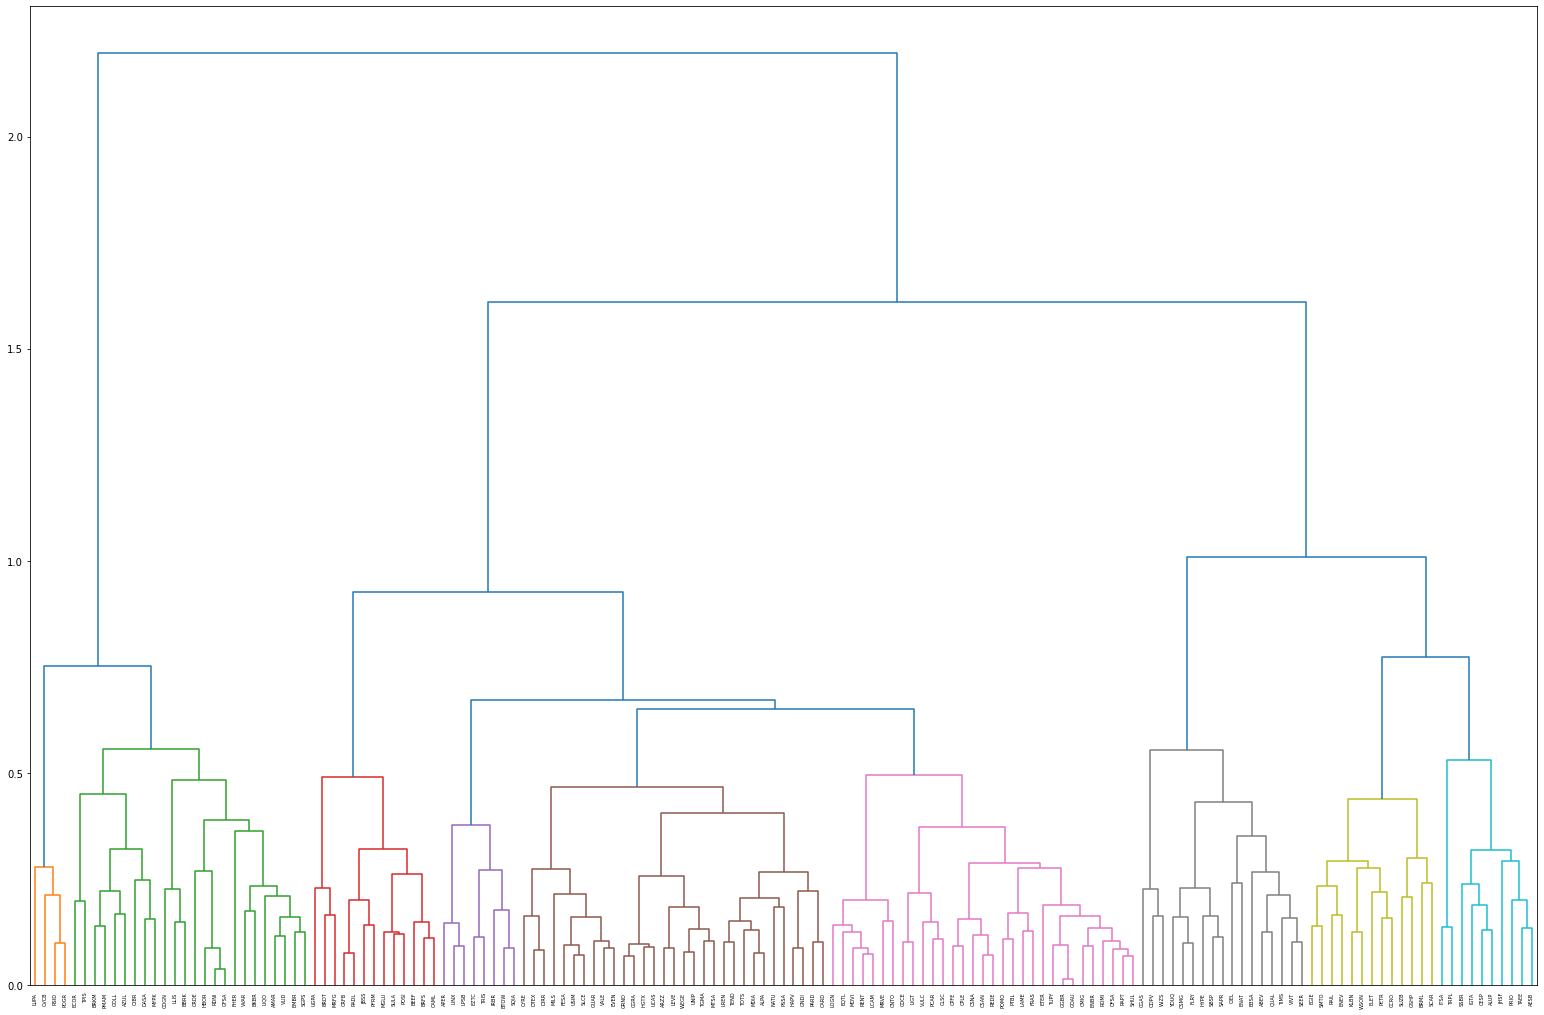

In [6]:
plt.figure(figsize=(27,18))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True,
            color_threshold=0.6
          )
axes = plt.gca()
plt.savefig('_dendogram.pdf')
plt.show()

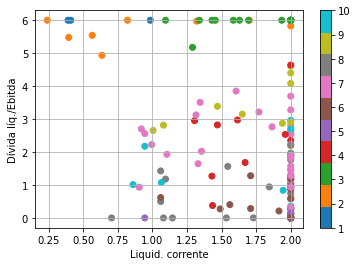

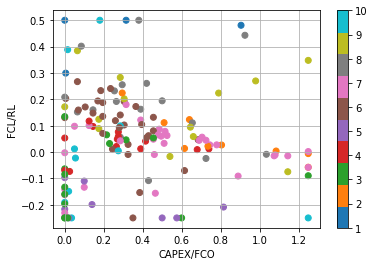

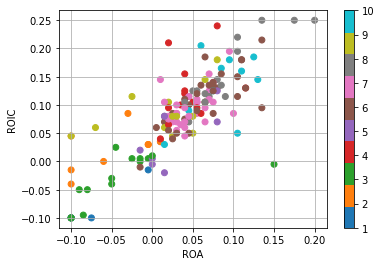

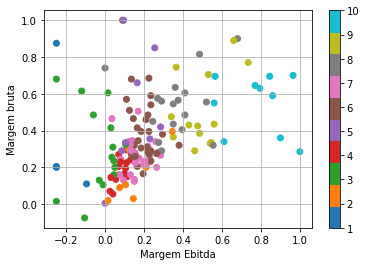

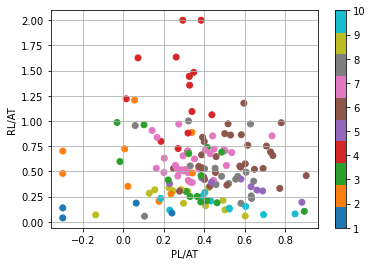

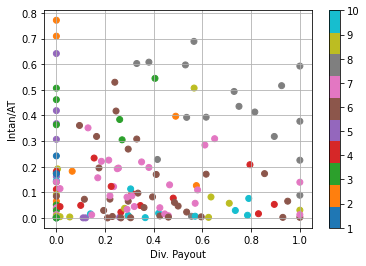

In [7]:
colors = scipy.cluster.hierarchy.fcluster(linked, 10, criterion='maxclust').tolist()

N = int(np.floor(len(param_list)/2))
M = int(np.floor((N+1)/2))
# plt.figure(figsize=(15, 5*M))
for n in range(0,N):
#     plt.subplot(M,2,n+1)
    plt.scatter(X[:,2*n], X[:,2*n+1], c=colors, cmap='tab10') # cmap = ['g', 'r', 'c', 'm', 'y', 'k']
    plt.xlabel(param_list[2*n])
    plt.ylabel(param_list[2*n+1])
    plt.grid()
    plt.colorbar()
    s = '_parameter_space_'+str(n)+'.pdf'
    plt.savefig(s)
    plt.show()

In [8]:
dfX=pd.DataFrame(X,columns=param_list,index=labelList)
cluster = scipy.cluster.hierarchy.fcluster(linked, 10, criterion='maxclust') # criterion = 'maxclust', 'distance'
dfX['cluster'] = cluster

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dfX[(dfX['cluster'] == 10)])

,Liquid. corrente,Dívida líq./Ebitda,CAPEX/FCO,FCL/RL,ROA,ROIC,Margem Ebitda,Margem bruta,PL/AT,RL/AT,Div. Payout,Intan/AT,cluster
ITSA,2.000,0.104735,0.180,0.500000,0.130,0.145,1.000,0.285,0.850010,0.077605,0.785,0.010447,10
TAEE,2.000,2.697228,0.050,0.011907,0.125,0.185,0.845,0.695,0.432920,0.206114,0.570,0.006628,10
CESP,1.065,1.072606,0.020,-0.149175,0.105,0.050,0.610,0.340,0.523890,0.126627,0.305,0.113273,10
IGTA,2.000,2.961051,0.035,-0.250000,0.045,0.090,0.795,0.630,0.229785,0.116185,0.420,0.018307,10
ALUP,2.000,1.913025,0.000,-0.190979,0.085,0.165,0.560,0.550,0.392727,0.254525,0.295,0.009135,10
AESB,0.945,2.175165,0.285,0.099199,0.060,0.205,0.770,0.645,0.184825,0.231589,0.790,0.075967,10
TRPL,2.000,0.356203,0.015,0.388296,0.110,0.160,0.965,0.700,0.605743,0.151655,0.365,0.001067,10
SSBR,2.000,0.000000,0.055,-0.022850,0.015,0.030,0.565,0.695,0.694402,0.070667,0.735,0.029047,10
PRIO,0.860,1.010395,0.275,0.004585,0.095,0.180,0.900,0.360,0.403312,0.290083,0.000,0.144880,10
JHSF,1.945,0.838295,1.250,-0.250000,0.075,0.125,0.860,0.590,0.524481,0.134815,0.140,0.015896,10


In [10]:
for k in range(1,11):
    print(k,':',round(100*len(dfX[(dfX['cluster'] == k)].index)/len(dfX.index)),'%')

print('\n')

for k in range(1,11):
    print(k,':',len(dfX[(dfX['cluster'] == k)].index))

1 : 3 %
2 : 6 %
3 : 10 %
4 : 9 %
5 : 5 %
6 : 21 %
7 : 21 %
8 : 11 %
9 : 9 %
10 : 7 %


1 : 4
2 : 9
3 : 15
4 : 13
5 : 8
6 : 31
7 : 31
8 : 17
9 : 13
10 : 10


In [11]:
Y = []
Z = []
for k in range(1,11):
    Y.append(np.array(dfX[(dfX['cluster'] == k)].drop('cluster',axis='columns').mean(axis=0)))
    Z.append(np.array(dfX[(dfX['cluster'] == k)].drop('cluster',axis='columns').std(axis=0)))
dfY = pd.DataFrame(Y, columns=param_list, index=range(1,11))
display(dfY)
dfZ = pd.DataFrame(Z, columns=param_list, index=range(1,11))
display(dfZ)

display(dfX.mean(axis=0))

,Liquid. corrente,Dívida líq./Ebitda,CAPEX/FCO,FCL/RL,ROA,ROIC,Margem Ebitda,Margem bruta,PL/AT,RL/AT,Div. Payout,Intan/AT
1,0.946250,6.000000,0.306250,0.445057,-0.070000,-0.078750,-0.211250,0.347500,-0.074000,0.111873,0.000000,0.104360
2,1.075000,5.750556,0.798333,0.051216,-0.054444,0.007778,0.146111,0.170000,0.064157,0.590561,0.125556,0.260396
3,1.697000,5.945154,0.205333,-0.093101,-0.040667,-0.034667,-0.030667,0.297333,0.336686,0.468355,0.062333,0.198062
4,1.760385,1.808644,0.277308,0.031103,0.045000,0.120385,0.080000,0.183077,0.275874,1.332597,0.339615,0.097250
5,1.868125,0.018314,0.268750,-0.197804,0.023125,0.038750,0.152500,0.489375,0.562881,0.348547,0.061250,0.237473
6,1.917581,0.468025,0.281774,0.098318,0.064194,0.109516,0.191935,0.396774,0.533259,0.636594,0.394489,0.118583
7,1.724355,2.121054,0.515806,-0.003017,0.047903,0.096452,0.174032,0.255323,0.345899,0.613618,0.330968,0.117542
8,1.576471,0.738741,0.403235,0.187473,0.083824,0.148235,0.368235,0.542059,0.470319,0.484195,0.708235,0.410467
9,1.780385,3.613388,0.539615,0.165879,0.014615,0.086154,0.498077,0.506154,0.303980,0.231073,0.321974,0.091929
10,1.681500,1.312870,0.216500,0.014098,0.084500,0.133500,0.787000,0.549000,0.484210,0.165986,0.440500,0.042465


,Liquid. corrente,Dívida líq./Ebitda,CAPEX/FCO,FCL/RL,ROA,ROIC,Margem Ebitda,Margem bruta,PL/AT,RL/AT,Div. Payout,Intan/AT
1,0.754734,0.000000,0.425487,0.097570,0.044907,0.042500,0.077500,0.354366,0.270780,0.063533,0.000000,0.122291
2,0.692843,0.368489,0.333429,0.085835,0.047398,0.054263,0.100678,0.124925,0.241115,0.321909,0.232667,0.296578
3,0.317343,0.212419,0.348022,0.133557,0.064111,0.045766,0.107718,0.225094,0.223315,0.289109,0.132623,0.207838
4,0.276944,1.434032,0.235634,0.056210,0.028504,0.055055,0.034761,0.072040,0.120158,0.418578,0.319266,0.071209
5,0.372999,0.051800,0.315558,0.061471,0.036443,0.049262,0.098271,0.325351,0.204286,0.078311,0.095684,0.236511
6,0.208338,0.527186,0.159256,0.111507,0.037330,0.048603,0.060093,0.174979,0.162112,0.212692,0.255803,0.140756
7,0.405152,0.910808,0.386079,0.103409,0.022612,0.031786,0.062549,0.088440,0.128543,0.157186,0.255990,0.097479
8,0.454934,0.799269,0.291665,0.161625,0.048687,0.060362,0.148975,0.168486,0.178514,0.269384,0.235484,0.191241
9,0.367018,1.323455,0.413881,0.137109,0.051456,0.040577,0.116396,0.198664,0.193070,0.103659,0.346284,0.139724
10,0.502820,1.065080,0.378653,0.256697,0.036473,0.059069,0.160212,0.160551,0.202173,0.075466,0.273724,0.050803


Liquid. corrente      1.698046
Dívida líq./Ebitda    2.261682
CAPEX/FCO             0.384139
FCL/RL                0.053678
ROA                   0.035265
ROIC                  0.082583
Margem Ebitda         0.226623
Margem bruta          0.365397
PL/AT                 0.380558
RL/AT                 0.559945
Div. Payout           0.331721
Intan/AT              0.164328
cluster               6.059603
dtype: float64

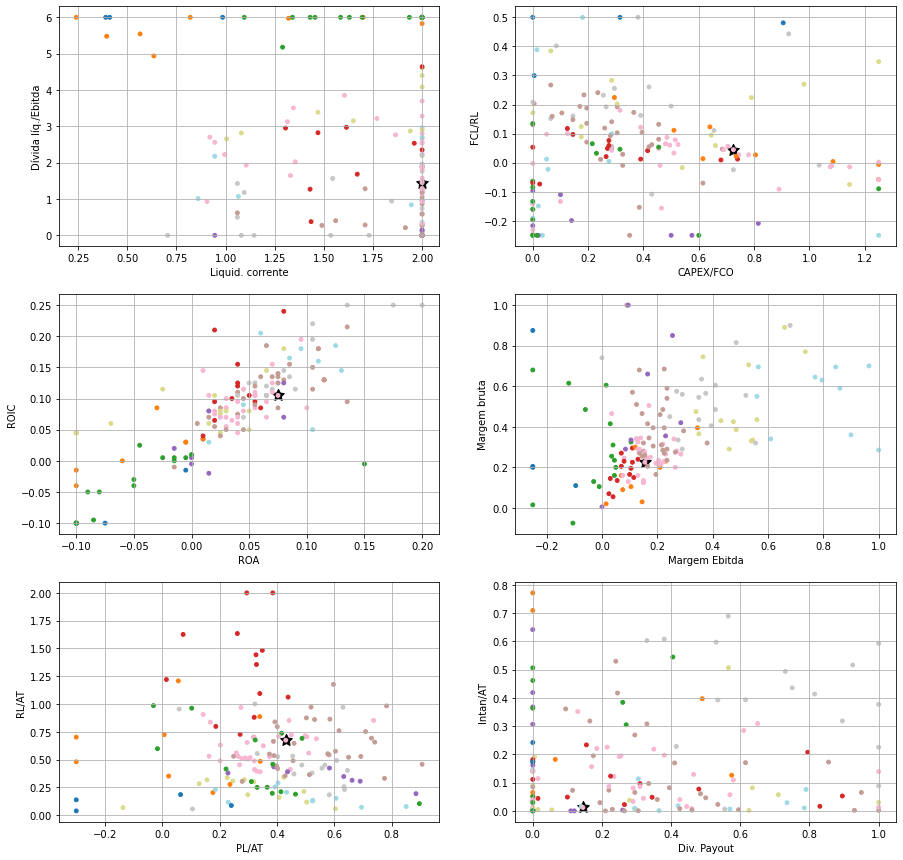

In [12]:
stocks = ['SHUL']
# stocks = ['PSSA','FRAS','ENAT','HAPV','BRAP','UNIP']
# stocks = dfX[(dfX['cluster'] == 1)].index

colors = fcluster(linked, 10, criterion='maxclust').tolist()
xx = np.array(dfX.loc[stocks])

plt.figure(figsize=(15, 5*M))
for n in range(0,N):
    plt.subplot(M,2,n+1)
    plt.scatter(xx[:,2*n], xx[:,2*n+1], c='black', marker=(5, 1), s=150)
    plt.scatter(X[:,2*n], X[:,2*n+1], c=colors, cmap='tab20', s=15)
    plt.xlabel(param_list[2*n])
    plt.ylabel(param_list[2*n+1])
    plt.grid()
plt.show()

In [13]:
# stocks = ['EGIE','LAME']
# dfX.loc[stocks]
dfX.loc['EGIE']

Liquid. corrente      2.000000
Dívida líq./Ebitda    1.907800
CAPEX/FCO             0.540000
FCL/RL               -0.016896
ROA                   0.080000
ROIC                  0.180000
Margem Ebitda         0.560000
Margem bruta          0.435000
PL/AT                 0.226112
RL/AT                 0.336871
Div. Payout           0.710000
Intan/AT              0.057213
cluster               9.000000
Name: EGIE, dtype: float64

In [14]:
Xn = preprocessing.normalize(X, axis=0) # normalize per feature
linked = linkage(Xn, 'single') # single, average, complete, ward
DB_score = []
Si_score = []
CH_score = []
for k in range(2,51):
    cluster = fcluster(linked, k, criterion='maxclust')
    DB_score.append([k,metrics.davies_bouldin_score(Xn,cluster)])
    Si_score.append([k,metrics.silhouette_score(Xn,cluster)]) 
#     CH_score.append([k,metrics.calinski_harabasz_score(Xn,cluster)])
DB_score_single = np.array(DB_score)
Si_score_single = np.array(Si_score)


Xn = preprocessing.normalize(X, axis=0)
linked = linkage(Xn, 'average') # single, average, complete, ward
DB_score = []
Si_score = []
CH_score = []
for k in range(2,51):
    cluster = fcluster(linked, k, criterion='maxclust')
    DB_score.append([k,metrics.davies_bouldin_score(Xn,cluster)])
    Si_score.append([k,metrics.silhouette_score(Xn,cluster)]) 
#     CH_score.append([k,metrics.calinski_harabasz_score(Xn,cluster)])
DB_score_average = np.array(DB_score)
Si_score_average = np.array(Si_score)

Xn = preprocessing.normalize(X, axis=0)
linked = linkage(Xn, 'complete') # single, average, complete, ward
DB_score = []
Si_score = []
CH_score = []
for k in range(2,51):
    cluster = fcluster(linked, k, criterion='maxclust')
    DB_score.append([k,metrics.davies_bouldin_score(Xn,cluster)])
    Si_score.append([k,metrics.silhouette_score(Xn,cluster)]) 
#     CH_score.append([k,metrics.calinski_harabasz_score(Xn,cluster)])
DB_score_complete = np.array(DB_score)
Si_score_complete = np.array(Si_score)

Xn = preprocessing.normalize(X, axis=0)
linked = linkage(Xn, 'ward') # single, average, complete, ward
DB_score = []
Si_score = []
CH_score = []
for k in range(2,51):
    cluster = fcluster(linked, k, criterion='maxclust')
    DB_score.append([k,metrics.davies_bouldin_score(Xn,cluster)])
    Si_score.append([k,metrics.silhouette_score(Xn,cluster)]) 
#     CH_score.append([k,metrics.calinski_harabasz_score(Xn,cluster)])
DB_score_ward = np.array(DB_score)
Si_score_ward = np.array(Si_score)

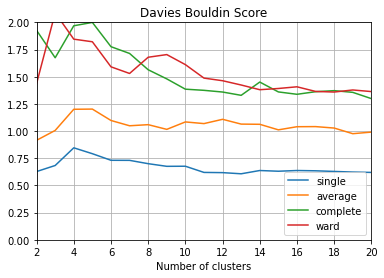

In [15]:
plt.plot(DB_score_single[:,0],DB_score_single[:,1],)
plt.plot(DB_score_average[:,0],DB_score_average[:,1],)
plt.plot(DB_score_complete[:,0],DB_score_complete[:,1],)
plt.plot(DB_score_ward[:,0],DB_score_ward[:,1],)
plt.legend(('single','average','complete', 'ward'),
           loc='lower right')
axes = plt.gca()
axes.set_xlim([2,20])
axes.set_ylim([0,2])
axes.set_title('Davies Bouldin Score')
axes.set_xlabel('Number of clusters')
plt.grid()
plt.savefig('_davies_bouldin.pdf')
plt.show()

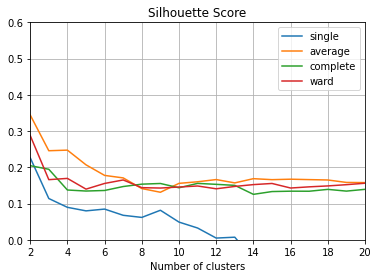

In [16]:
plt.plot(Si_score_single[:,0],Si_score_single[:,1],)
plt.plot(Si_score_average[:,0],Si_score_average[:,1],)
plt.plot(Si_score_complete[:,0],Si_score_complete[:,1],)
plt.plot(Si_score_ward[:,0],Si_score_ward[:,1],)
plt.legend( ('single','average','complete', 'ward'),
            loc='upper right')
axes = plt.gca()
axes.set_xlim([2,20])
axes.set_ylim([0,0.6])
axes.set_title('Silhouette Score')
axes.set_xlabel('Number of clusters')
plt.grid()
plt.savefig('_silhouette_score.pdf')
plt.show()

In [17]:
Xn

array([[0.04657748, 0.06951842, 0.01021633, ..., 0.0366803 , 0.11467836,
        0.02693962],
       [0.05005341, 0.        , 0.04007947, ..., 0.05991875, 0.11106644,
        0.12961796],
       [0.0926915 , 0.02481129, 0.04793819, ..., 0.05107923, 0.06049961,
        0.03192999],
       ...,
       [0.0926915 , 0.05796257, 0.06758498, ..., 0.06475476, 0.16163328,
        0.10483298],
       [0.07855605, 0.15713947, 0.19646798, ..., 0.02298133, 0.07314132,
        0.17957225],
       [0.05306588, 0.        , 0.07858719, ..., 0.05150537, 0.07494728,
        0.0752217 ]])

In [18]:
len(dfX.index)

151

In [19]:
dfX.index

Index(['PETR', 'ABEV', 'VALE', 'ITSA', 'GOLL', 'VIVT', 'B3SA', 'JBSS', 'AZUL',
       'ELET',
       ...
       'RSID', 'ETER', 'GSHP', 'PDGR', 'CRDE', 'LUPA', 'LIQO', 'YDUQ', 'COGN',
       'TIMS'],
      dtype='object', length=151)

In [20]:
param_list.index('Dívida líq./Ebitda')

1

In [21]:
param_list

['Liquid. corrente',
 'Dívida líq./Ebitda',
 'CAPEX/FCO',
 'FCL/RL',
 'ROA',
 'ROIC',
 'Margem Ebitda',
 'Margem bruta',
 'PL/AT',
 'RL/AT',
 'Div. Payout',
 'Intan/AT']

In [22]:
Xn[:,2] = Xn[:,2]
Xn

array([[0.04657748, 0.06951842, 0.01021633, ..., 0.0366803 , 0.11467836,
        0.02693962],
       [0.05005341, 0.        , 0.04007947, ..., 0.05991875, 0.11106644,
        0.12961796],
       [0.0926915 , 0.02481129, 0.04793819, ..., 0.05107923, 0.06049961,
        0.03192999],
       ...,
       [0.0926915 , 0.05796257, 0.06758498, ..., 0.06475476, 0.16163328,
        0.10483298],
       [0.07855605, 0.15713947, 0.19646798, ..., 0.02298133, 0.07314132,
        0.17957225],
       [0.05306588, 0.        , 0.07858719, ..., 0.05150537, 0.07494728,
        0.0752217 ]])

In [23]:
print(df.index.tolist())

['Receita líquida', 'Custos', 'Resultado bruto', 'Margem bruta', 'Despesas oper.', 'Res. operacional', 'Margem Oper.', 'Res. Financeiro', 'IR e CSSL', 'Op. descontin.', 'Lucro líquido', 'Margem líquida', 'LPA', 'P/L', 'VPA', 'P/VP', 'P/EBIT', 'P/EBITDA', 'P/Ativos', 'Ebitda', 'Margem Ebitda', 'PSR', 'ROE', 'ROA', 'ROIC', 'EV/EBIT', 'EV/EBITDA', 'Div. Yield', 'Div. Payout', 'Beta (diário 12m)', 'Valorização', 'Negócios diário', 'Volume diário', 'Patrimônio líq.', 'Disponibilidades', 'Dívida bruta', 'Dívida líq.', 'Dívida bruta/PL', 'Dívida líq./Ebitda', 'EF', 'ECP', 'FCO', 'FCI', 'FCF', 'FCT', 'FCL', 'FCI/LL', 'CAPEX', 'CAPEX/LL', 'CAPEX/FCO', 'Ativo Total', 'Ativo Circulante', 'Caixa', 'Recebíveis', 'Estoque', 'Outros AC', 'Ativo Não Circ.', 'Imobilizado', 'Intangível', 'Outros ANC', 'Passivo Total', 'Passivo Circ.', 'Fornecedores', 'Emprést. CP', 'Outros PC', 'Passivo Não Circ.', 'Emprést. LP', 'Outros PNC', 'Patrimônio Líq.', 'Liquid. corrente', 'Liquid. imediata', 'Capital de giro',

In [24]:
df

,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Receita líquida,125,680,716,791,891,1.087,2.564,2.918,10.116,12.441,...,18.763,19.921,19.498,17.138,15.617,16.233,16.981,17.377,17.267,NaN
Custos,-52,-439,-419,-406,-486,-576,-1.293,-1.377,-5.504,-6.731,...,-9.885,-10.822,-10.083,-8.306,-7.693,-7.740,-7.701,-7.433,-7.996,NaN
Resultado bruto,73,241,297,385,405,511,1.271,1.541,4.612,5.710,...,8.878,9.099,9.415,8.832,7.924,8.493,9.280,9.944,9.271,NaN
Margem bruta,58%,35%,41%,49%,45%,47%,50%,53%,46%,46%,...,47%,46%,48%,52%,51%,52%,55%,57%,54%,NaN
Despesas oper.,-73,-178,-231,-266,-288,-356,-888,-1.062,-4.401,-5.188,...,-6.557,-6.663,-6.928,-5.587,-6.499,-6.560,-6.862,-5.428,-6.456,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Capital de giro,55,-148,95,205,221,334,630,833,308,232,...,2.592,2.6919999999999997,2.051,3.375,2.826,383,-1.077,337,2.11,NaN
Intan/AT,0,0,0,0,0,0,0,0,0,0,...,0.229393,0.22873,0.28512,0.281304,0.306796,0.346994,0.334262,0.239615,0.216714,NaN
FCL/RL,0,0,0,0,0,0,0,0,0.00286675,0.102966,...,0.0742419,0.0854877,-0.0216432,0.0848407,0.0475764,0.0618493,0.135387,0.192899,0.195749,NaN
PL/AT,0.750276,0.59809,0.62423,0.637816,0.609593,0.674817,0.671301,0.625998,0.555352,0.532793,...,0.529799,0.518658,0.468634,0.478293,0.495946,0.556779,0.619395,0.555938,0.556537,NaN
